# EcoFOCI M2 near sfc Datasets

- erddap source: https://akutan.pmel.noaa.gov/erddap
- 2010+
- BS
- Peggy/Prawler

***Todo:***
- extend M2 back through 1995
- compare against upper 1m and upper 5m (winds should tell if the two are identical) (Niller - mixing for winds)
- choose AMSR/AMSS
- standard deviation of daily means of M2 SST
- daily variability (seasonally)
- find M8 paper (because this has info on how good M8 was vs M2 and what model we used with most reliability)

**Other Sites**
- C2

In [4]:
import datetime
from erddapy import ERDDAP
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import cmocean

#using xarray for bathymetry data read
import xarray as xa

In [10]:
#search and boundary parameters

server_url = 'http://akutan.pmel.noaa.gov:8080/erddap/'

deployments = []

constraints = {
    'time>=': '1995-01-01T00:00:00Z',
    'time<=': datetime.datetime.utcnow().strftime('%Y-%m-%dT00:00:00Z'),
    'depth>=': 0,
    'depth<=': 4,
}

extent=[-179.5, -150, 52.5, 72]
variables = ['latitude, longitude, temperature, time, depth']


In [11]:
e = ERDDAP(server=server_url)
df_1 = pd.read_csv(e.get_search_url(response='csv', search_for='bs2 -CTD -ADCP -EcoFOCI_Bering_Sea_timeseries_data -gridded  -preliminary'))
e = ERDDAP(server=server_url)
df_2 = pd.read_csv(e.get_search_url(response='csv', search_for='bsm2 -meteorological -ADCP -gridded -preliminary'))
#e = ERDDAP(server=server_url)
#df_3 = pd.read_csv(e.get_search_url(response='csv', search_for='bsitae'))
df_3=['datasets_Mooring_19bsm2a_preliminary']
df = pd.concat([df_1,df_2])
print(df['Dataset ID'].values)

['datasets_Mooring_01bs2c_final' 'datasets_Mooring_02bs2c_final'
 'datasets_Mooring_03bs2a_final' 'datasets_Mooring_03bs2c_final'
 'datasets_Mooring_04bs2c_final' 'datasets_Mooring_05bs2c_final'
 'datasets_Mooring_06bs2c_final' 'datasets_Mooring_07bs2c_final'
 'datasets_Mooring_08bs2c_final' 'datasets_Mooring_09bs2c_final'
 'datasets_Mooring_10bs2c_final' 'datasets_Mooring_11bs2c_final'
 'datasets_Mooring_12bs2c_final' 'datasets_Mooring_13bs2c_final'
 'datasets_Mooring_14bs2c_final' 'datasets_Mooring_15bs2c_final'
 'datasets_Mooring_16bs2c_final' 'datasets_Mooring_18bs2c_final'
 'datasets_Mooring_96bs2a_final' 'datasets_Mooring_96bs2b_final'
 'datasets_Mooring_96bs2c_final' 'datasets_Mooring_97bs2a_final'
 'datasets_Mooring_97bs2b_final' 'datasets_Mooring_97bs2c_final'
 'datasets_Mooring_98bs2a_final' 'datasets_Mooring_98bs2b_final'
 'datasets_Mooring_98bs2c_final' 'datasets_Mooring_99bs2a_final'
 'datasets_Mooring_99bs2c_final' 'datasets_Mooring_00bsp2w_final'
 'datasets_Mooring_00bsm

In [12]:
from requests.exceptions import HTTPError

dfs = {}
for dataset_id in df['Dataset ID'].values:
    print(dataset_id)
    try:
        d = ERDDAP(server=server_url,
            protocol='tabledap',
            response='csv'
        )
        d.dataset_id=dataset_id
        d.variables = variables
        d.constraints = constraints
    except HTTPError:
        print('Failed to generate url {}'.format(dataset_id))

    try:
        df_m = d.to_pandas(
                    index_col='time (UTC)',
                    parse_dates=True,
                    skiprows=(1,)  # units information can be dropped.
                    )
        df_m.sort_index(inplace=True)
        df_m.columns = [x[1].split()[0] for x in enumerate(df_m.columns)]
        
        #-9999 and 1e35 are missing values... but erddap doesn't catch the -9999 yet 
        #and some 1e35 are off a bit
        df_m['depth'][(df_m.depth == -9999)] = np.nan # only in pressure field
        dfs.update({dataset_id:df_m})
    except:
        pass


datasets_Mooring_01bs2c_final
datasets_Mooring_02bs2c_final
datasets_Mooring_03bs2a_final
datasets_Mooring_03bs2c_final
datasets_Mooring_04bs2c_final
datasets_Mooring_05bs2c_final
datasets_Mooring_06bs2c_final
datasets_Mooring_07bs2c_final
datasets_Mooring_08bs2c_final
datasets_Mooring_09bs2c_final
datasets_Mooring_10bs2c_final
datasets_Mooring_11bs2c_final
datasets_Mooring_12bs2c_final
datasets_Mooring_13bs2c_final
datasets_Mooring_14bs2c_final
datasets_Mooring_15bs2c_final
datasets_Mooring_16bs2c_final
datasets_Mooring_18bs2c_final
datasets_Mooring_96bs2a_final
datasets_Mooring_96bs2b_final
datasets_Mooring_96bs2c_final
datasets_Mooring_97bs2a_final
datasets_Mooring_97bs2b_final
datasets_Mooring_97bs2c_final
datasets_Mooring_98bs2a_final
datasets_Mooring_98bs2b_final
datasets_Mooring_98bs2c_final
datasets_Mooring_99bs2a_final
datasets_Mooring_99bs2c_final
datasets_Mooring_00bsp2w_final
datasets_Mooring_00bsm2a_final
datasets_Mooring_01bsm2a_final
datasets_Mooring_02bsm2a_final
datase

**Note** Mooring data is hourly or better.  resample (on average) to daily (which will currently average all values from 0-5m)

**Question** is a daily average of moored data appropriate?  If the model has an "error" and the daily average has a range, are we comparing apples to apples
- what is the daily variance?
- should a time of day be chosen? to compare against the model data

This may be more relevant when comparing against CTD data choosing whether the data is representative or not

In [63]:
dfh= {}
dfstd={}
for dataset in dfs:
    dfh[dataset] = (dfs[dataset].resample('1D').mean())
    dfstd[dataset] = (dfs[dataset].resample('1D').std())

#groupby hour and see if there is a daily trend
dfg={}
dfg_std={}
for dataset in dfs:
    dtemp = dfs[dataset][(dfs[dataset].index.month >= 8) & (dfs[dataset].index.month <=8)]
    dfg[dataset] = (dtemp.groupby(dtemp.index.hour).mean())
    dfg_std[dataset] = (dtemp.groupby(dtemp.index.hour).std())


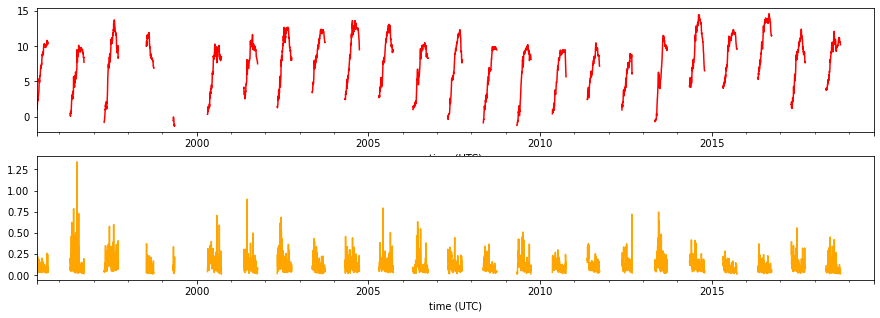

In [64]:
#daily thermal cycle
fig, [ax1,ax2] = plt.subplots(2,1, figsize=(10, 5), facecolor='w', edgecolor='k')
for dataset in dfh:
    (dfh[dataset].temperature).plot(color='red',figsize=(15,5),ax=ax1)
    (dfstd[dataset].temperature).plot(color='orange',figsize=(15,5),ax=ax2)

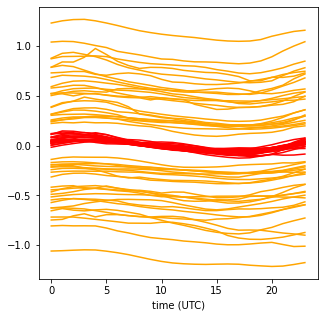

In [66]:
fig, ax1 = plt.subplots(1,1, figsize=(5, 5), facecolor='w', edgecolor='k')
for dataset in dfh:
    (dfg[dataset].temperature-dfg[dataset].temperature.mean()).plot(color='red',ax=ax1)
    (dfg[dataset].temperature-dfg[dataset].temperature.mean()+dfg_std[dataset].temperature).plot(color='orange',ax=ax1)
    (dfg[dataset].temperature-dfg[dataset].temperature.mean()-dfg_std[dataset].temperature).plot(color='orange',ax=ax1)

So - there is a small diurnal trend in the average, but is it much smaller than the retrieval/satellite sensitivity? but its not likely to matter if its morning or evening data point for this comparison, more importantly would be how the analysis sees strong events that set the variability.

In [18]:
#open_dataset vs load_dataset
# as this is a stationary dataset, i can really zoom in on the region

#HROISST
xa_HROISST = xa.open_mfdataset('/Users/bell/in_and_outbox/data_sets/sst/NBS_SST_Models/HROISSTV2/NBS_CK_HROISST_*.nc')

xa_HROISST_subset = xa_HROISST.sel(time=slice('1995-01-01','2019-12-31'),
                                     latitude=slice(55,58),longitude=slice(194,196))

#UKMET
#centered at noon
xa_UKMET = xa.open_mfdataset('/Users/bell/in_and_outbox/data_sets/sst/NBS_SST_Models/UKMET/NBS_CK_UKMET_*.nc')

xa_UKMET_subset = xa_UKMET.sel(time=slice('2010-01-01','2019-12-31'),
                                     latitude=slice(55,58),longitude=slice(-166,-164))


#JPL MUR
xa_JPLMUR = xa.open_mfdataset('/Users/bell/in_and_outbox/data_sets/sst/NBS_SST_Models/JPLGHRSSTMUR/NBS_BS_MUR_*.nc')

xa_JPLMUR_subset = xa_JPLMUR.sel(time=slice('2010-01-01','2019-12-31'),
                                     latitude=slice(55,58),longitude=slice(-166,-164))



In [72]:
for dataset in dfs:
    print(dataset)
    dfh[dataset]['hroisst'] = np.nan
    dfh[dataset]['hroierr'] = np.nan
    dfh[dataset]['ukmetsst'] = np.nan
    dfh[dataset]['ukmeterror'] = np.nan
    dfh[dataset]['jplsst'] = np.nan
    dfh[dataset]['jplerror'] = np.nan
    for row, value in dfh[dataset].iterrows():
        dfh[dataset]['hroisst'][row] = xa_HROISST_subset.sst.sel(time=str(row),
                                                    latitude=value['latitude'],
                                                    longitude=value['longitude'],
                                                    method='nearest')
        dfh[dataset]['hroierr'][row] = xa_HROISST_subset.sst.sel(time=str(row),
                                                    latitude=value['latitude'],
                                                    longitude=value['longitude'],
                                                    method='nearest')
        dfh[dataset]['ukmetsst'][row] = xa_UKMET_subset.analysed_sst.sel(time=str(row),
                                                    latitude=value['latitude'],
                                                    longitude=value['longitude']-360,
                                                    method='nearest')
        dfh[dataset]['ukmeterror'][row] = xa_UKMET_subset.analysis_error.sel(time=str(row),
                                                    latitude=value['latitude'],
                                                    longitude=value['longitude']-360,
                                                    method='nearest')    
        dfh[dataset]['jplsst'][row] = xa_JPLMUR_subset.analysed_sst.sel(time=str(row),
                                                    latitude=value['latitude'],
                                                    longitude=value['longitude']-360,
                                                    method='nearest')
        dfh[dataset]['jplerror'][row] = xa_JPLMUR_subset.analysis_error.sel(time=str(row),
                                                    latitude=value['latitude'],
                                                    longitude=value['longitude']-360,
                                                    method='nearest')   

datasets_Mooring_00bsm2a_final
datasets_Mooring_01bsm2a_final
datasets_Mooring_02bsm2a_final
datasets_Mooring_03bsm2a_final
datasets_Mooring_04bsm2a_final
datasets_Mooring_05bsm2a_final
datasets_Mooring_06bsm2a_final
datasets_Mooring_07bsm2a_final
datasets_Mooring_08bsm2a_final
datasets_Mooring_09bsm2a_final
datasets_Mooring_10bsm2a_final
datasets_Mooring_11bsm2a_final
datasets_Mooring_12bsm2a_final
datasets_Mooring_13bsm2a_final
datasets_Mooring_14bsm2a_final
datasets_Mooring_15bsm2a_final
datasets_Mooring_16bsm2a_final
datasets_Mooring_17bsm2a_final
datasets_Mooring_18bsm2a_final
datasets_Mooring_19bsm2a_final
datasets_Mooring_95bsm2a_final
datasets_Mooring_96bsm2a_final
datasets_Mooring_97bsm2a_final
datasets_Mooring_98bsm2b_final
datasets_Mooring_99bsm2a_final


datasets_Mooring_00bsm2a_final
datasets_Mooring_01bsm2a_final
datasets_Mooring_02bsm2a_final
datasets_Mooring_03bsm2a_final
datasets_Mooring_04bsm2a_final
datasets_Mooring_05bsm2a_final
datasets_Mooring_06bsm2a_final
datasets_Mooring_07bsm2a_final
datasets_Mooring_08bsm2a_final
datasets_Mooring_09bsm2a_final
datasets_Mooring_10bsm2a_final
datasets_Mooring_11bsm2a_final
datasets_Mooring_12bsm2a_final
datasets_Mooring_13bsm2a_final
datasets_Mooring_14bsm2a_final
datasets_Mooring_15bsm2a_final
datasets_Mooring_16bsm2a_final
datasets_Mooring_17bsm2a_final
datasets_Mooring_18bsm2a_final
datasets_Mooring_19bsm2a_final
datasets_Mooring_95bsm2a_final
datasets_Mooring_96bsm2a_final
datasets_Mooring_97bsm2a_final
datasets_Mooring_98bsm2b_final
datasets_Mooring_99bsm2a_final
datasets_Mooring_00bsm2a_final
datasets_Mooring_01bsm2a_final
datasets_Mooring_02bsm2a_final
datasets_Mooring_03bsm2a_final
datasets_Mooring_04bsm2a_final
datasets_Mooring_05bsm2a_final
datasets_Mooring_06bsm2a_final
datasets

<ipython-input-73-f0391dac0c2a>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1,1, figsize=(10, 5), facecolor='w', edgecolor='k')


datasets_Mooring_95bsm2a_final
datasets_Mooring_96bsm2a_final
datasets_Mooring_97bsm2a_final
datasets_Mooring_98bsm2b_final
datasets_Mooring_99bsm2a_final


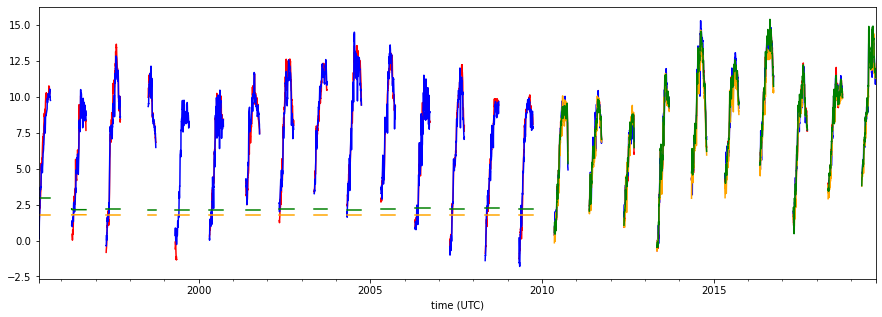

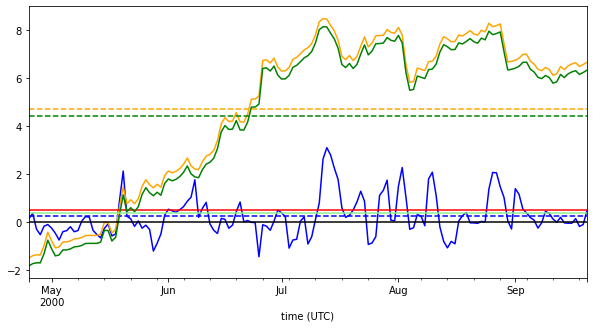

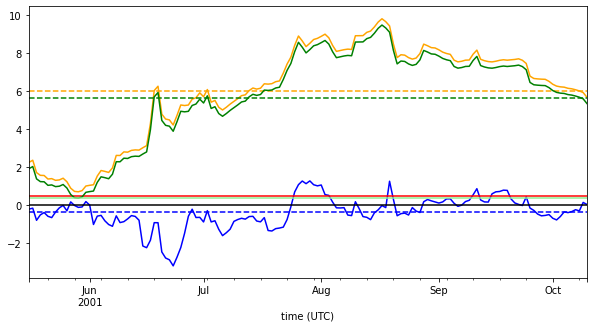

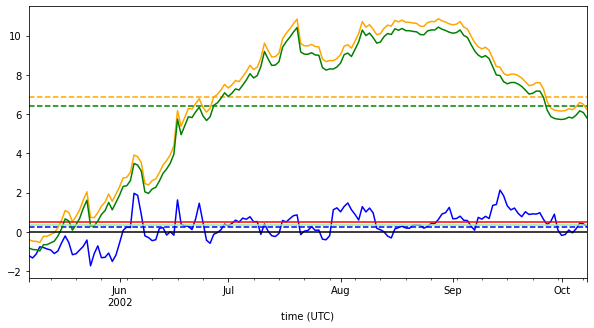

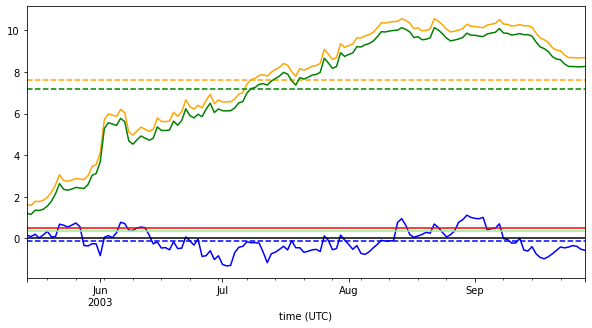

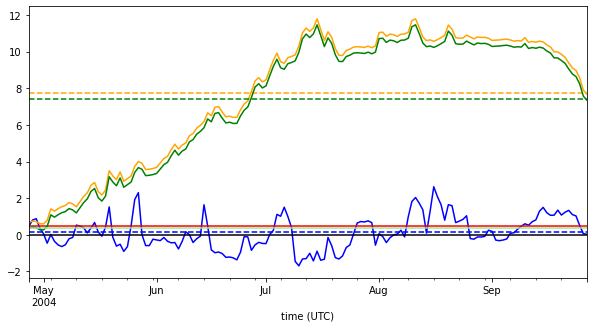

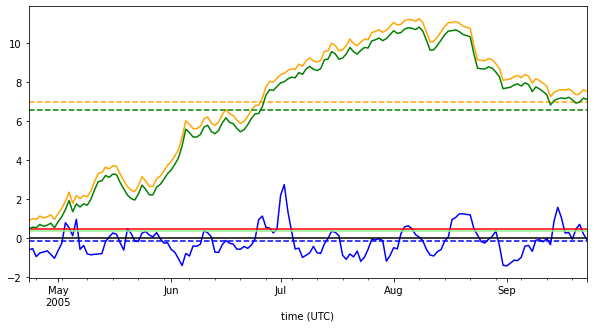

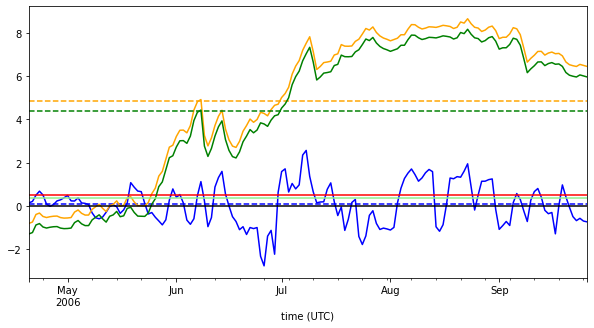

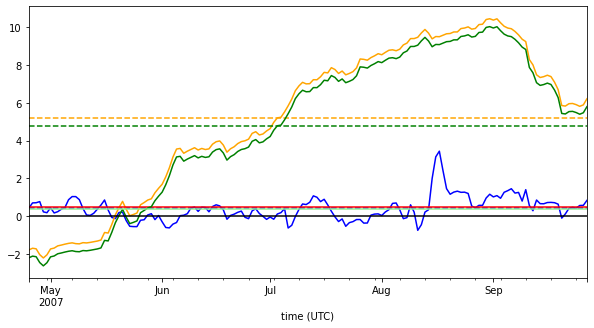

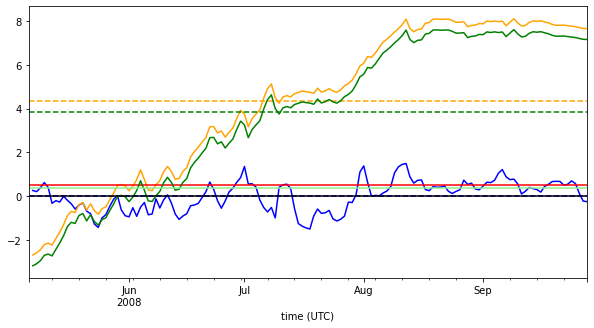

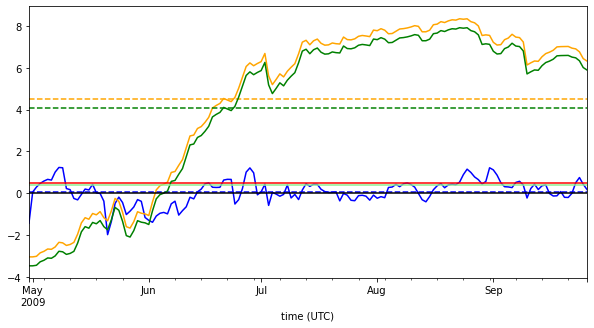

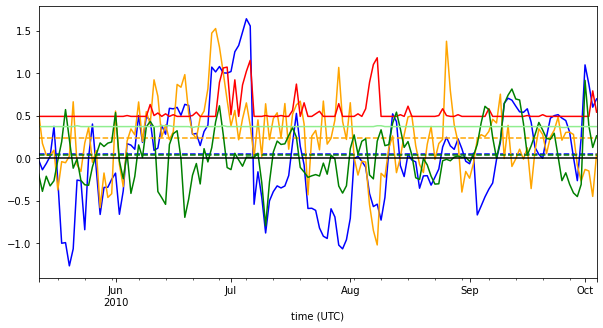

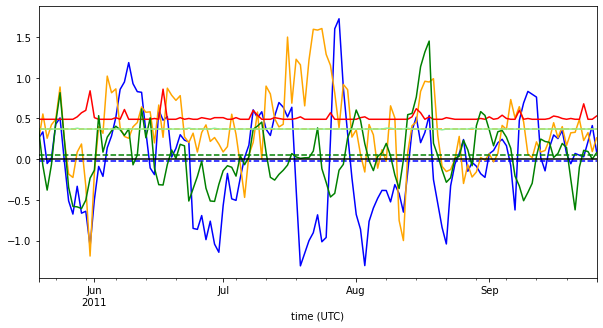

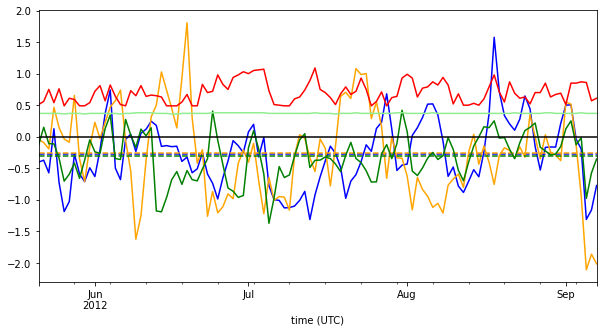

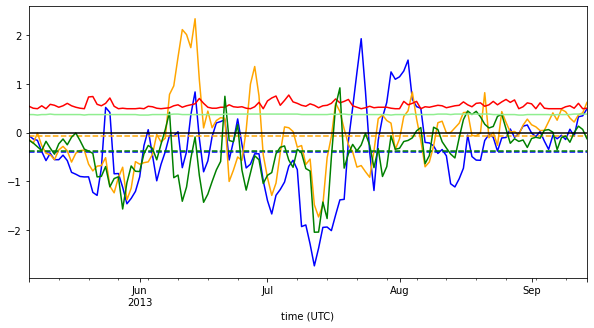

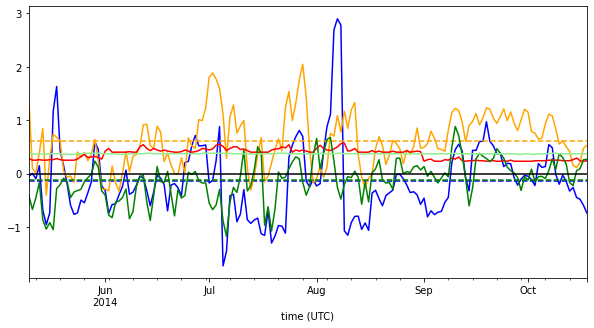

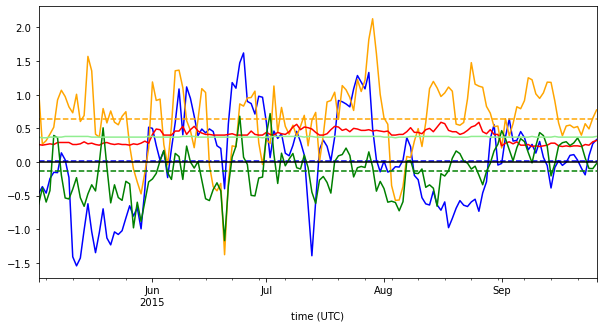

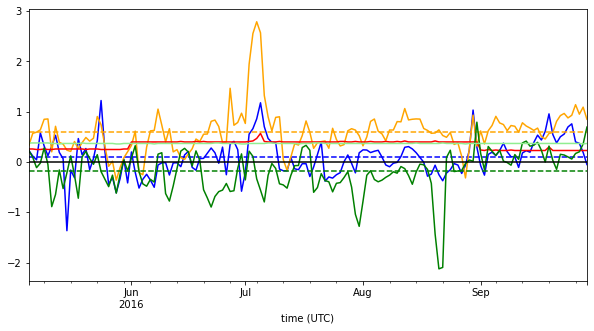

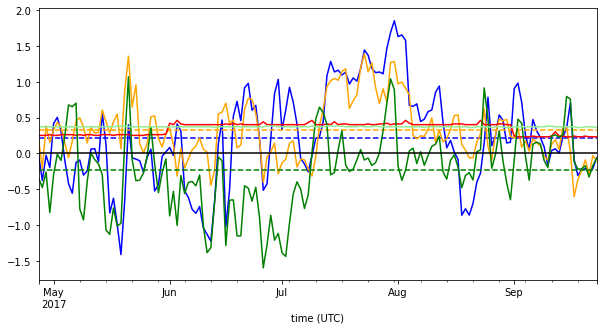

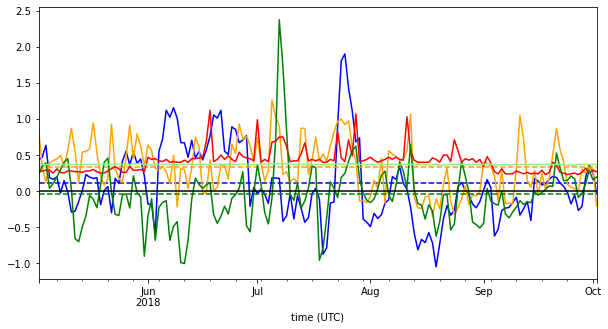

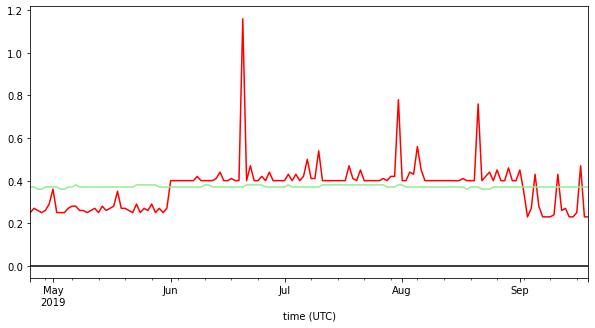

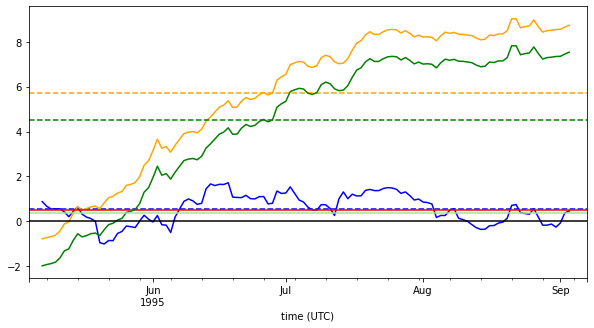

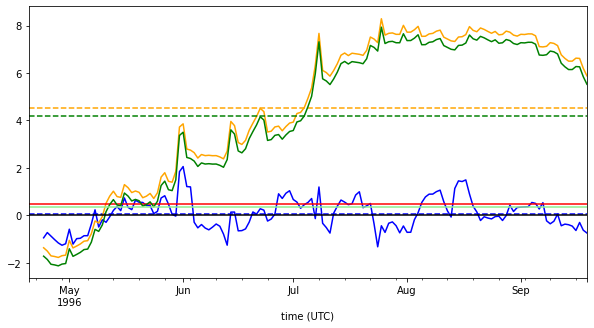

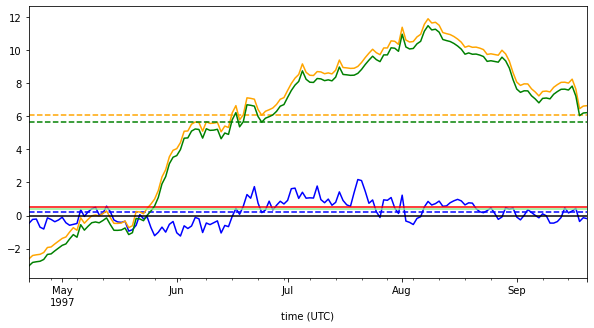

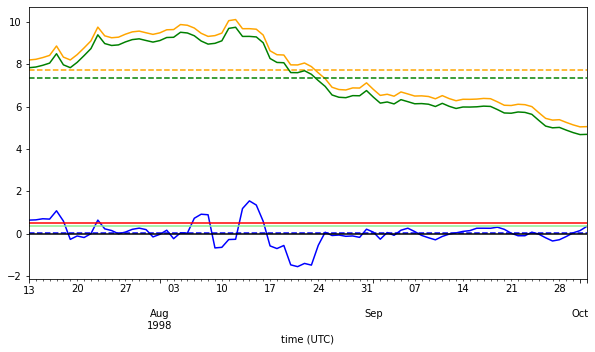

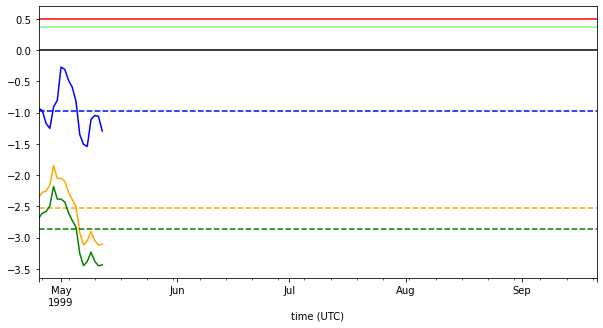

In [73]:
fig, axs = plt.subplots(1,1, figsize=(10, 5), facecolor='w', edgecolor='k')
for dataset in dfh:
    print(dataset)
    (dfh[dataset].temperature).plot(color='red',figsize=(15,5))
    (dfh[dataset].hroisst).plot(color='blue')
    (dfh[dataset].ukmetsst).plot(color='orange')
    (dfh[dataset].jplsst).plot(color='green')

    
for dataset in dfh:
    print(dataset)
    fig, axs = plt.subplots(1,1, figsize=(10, 5), facecolor='w', edgecolor='k')
    (dfh[dataset].temperature-dfh[dataset].hroisst).plot(color='blue',figsize=(10,5))
    (dfh[dataset].hroisst*0+(dfh[dataset].temperature-dfh[dataset].hroisst).mean()).plot(color='blue',linestyle='--')
    (dfh[dataset].temperature-dfh[dataset].ukmetsst).plot(color='orange')
    (dfh[dataset].ukmetsst*0+(dfh[dataset].temperature-dfh[dataset].ukmetsst).mean()).plot(color='orange',linestyle='--')
    dfh[dataset].ukmeterror.plot(c='red')
    (dfh[dataset].temperature-dfh[dataset].jplsst).plot(color='green')
    (dfh[dataset].jplsst*0+(dfh[dataset].temperature-dfh[dataset].jplsst).mean()).plot(color='green',linestyle='--')
    dfh[dataset].jplerror.plot(c='lightgreen')
    (dfh[dataset].ukmeterror*0).plot(c='black',linestyle='-')
